In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
t0=time.time()
df = pd.read_csv('lending-club-loan-data/loan.csv')
t1=time.time()
print('Read time: {}'.format(t1-t0))
warnings.filterwarnings("ignore")

Read time: 48.31394100189209


In [3]:
# df.head()

In [4]:
# df.info()

In [5]:
# list(df.columns)

In [6]:
df_cols = list(df.columns)

In [7]:
variables=['open_acc_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',\
           'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',\
           'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m','collections_12_mths_ex_med',\
           'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'revol_util','open_act_il' ]
for var in variables:
    df[var]=df[var].replace(np.nan,0)

In [8]:
variables1=['acc_now_delinq', 'open_acc', 'total_acc','pub_rec','delinq_2yrs','inq_last_6mths','earliest_cr_line']
for var1 in df[variables1]:
    df[var1]=df[var1].replace(np.nan, df[var1].mode())

In [9]:
df.loc[(df.mths_since_last_delinq.notnull()),'delinq']=1
df.loc[(df.mths_since_last_delinq.isnull()),'delinq']=0

df.loc[(df.mths_since_last_major_derog.notnull()),'derog']=1
df.loc[(df.mths_since_last_major_derog.isnull()),'derog']=0

df.loc[(df.mths_since_last_record.notnull()),'public_record']=1
df.loc[(df.mths_since_last_record.isnull()),'public_record']=0

df.loc[(df.mths_since_rcnt_il.notnull()), 'rcnt_il']=1
df.loc[(df.mths_since_rcnt_il.isnull()), 'rcnt_il']=0

df.loc[(df.mths_since_recent_bc.notnull()), 'rcnt_bc']=1
df.loc[(df.mths_since_recent_bc.isnull()), 'rcnt_bc']=0

df.loc[(df.mths_since_recent_bc_dlq.notnull()), 'rcnt_bc_delinq']=1
df.loc[(df.mths_since_recent_bc_dlq.isnull()), 'rcnt_bc_delinq']=0

df.loc[(df.mths_since_recent_inq.notnull()), 'rcnt_inq']=1
df.loc[(df.mths_since_recent_inq.isnull()), 'rcnt_inq']=0

df.loc[(df.mths_since_recent_revol_delinq.notnull()), 'rcnt_revol_delinq']=1
df.loc[(df.mths_since_recent_revol_delinq.isnull()), 'rcnt_revol_delinq']=0

df.drop(['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','mths_since_rcnt_il',\
         'mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq'\
        ],axis=1,inplace=True)

In [10]:
df_cols = list(df.columns)

In [11]:
cols_to_drop = ['funded_amnt', 'funded_amnt_inv','zip_code', 'out_prncp', 'out_prncp_inv',\
                'total_pymnt','total_pymnt_inv', 'total_rec_prncp', 'debt_settlement_flag',\
                'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_d',\
                'last_pymnt_amnt', 'last_credit_pull_d','total_rec_int','hardship_flag',\
                'chargeoff_within_12_mths','next_pymnt_d','issue_d','pymnt_plan','emp_title',\
                'policy_code', 'title']

# dropping the columns listed above  
df = df.drop(cols_to_drop, axis=1)

In [12]:
df_nulls = df.isnull().sum()

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

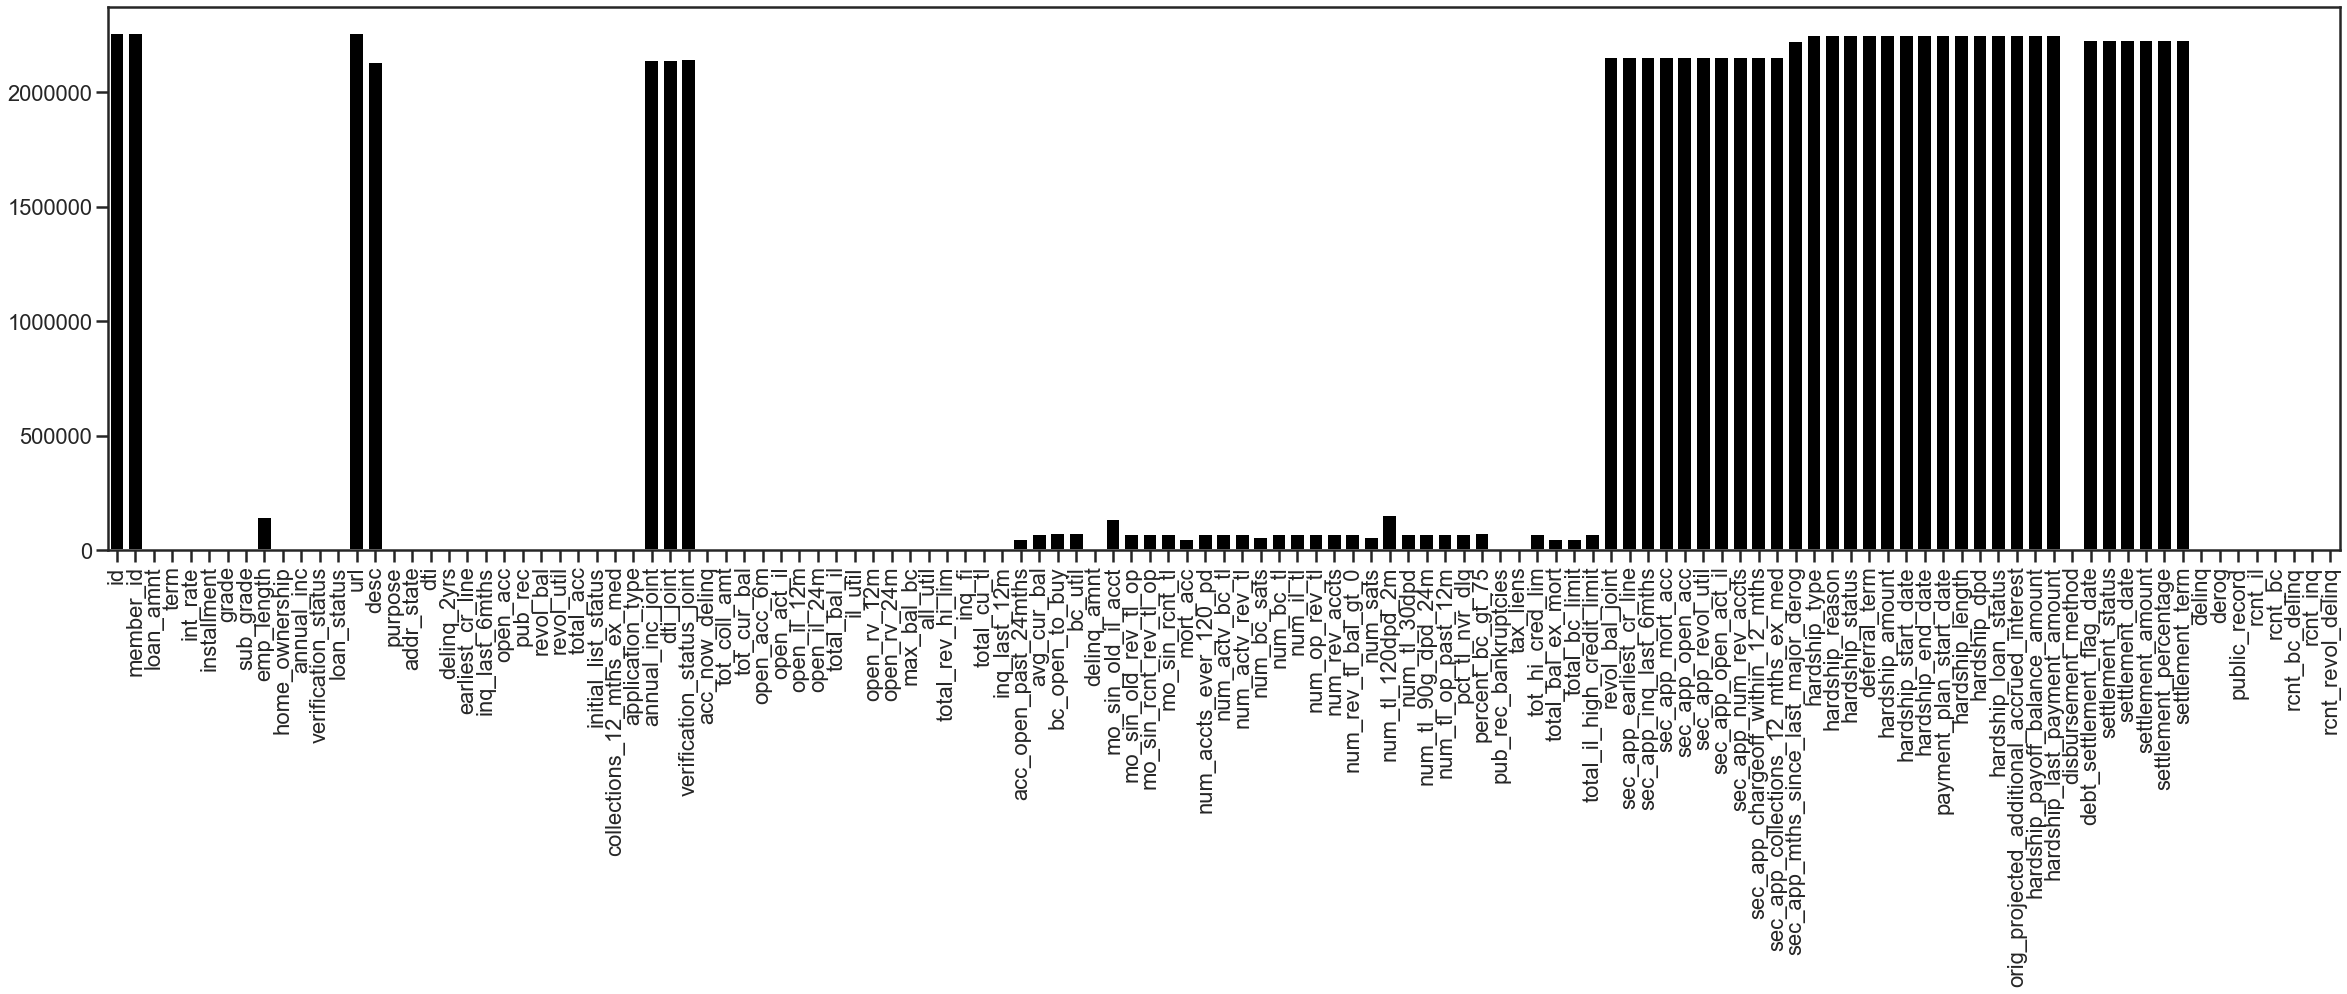

In [14]:
sns.set(context='poster',style='ticks',rc={'figure.figsize':(40,10)})
ax = sns.barplot(df_nulls.index, df_nulls.values, color='black')
plt.xticks(rotation=90)
plt.show()

In [15]:
df_nulls = pd.DataFrame(df_nulls)
df_nulls = df_nulls.rename(columns={0:'n_null'})
df_nulls['perc_null'] = df_nulls.values/len(df)

In [16]:
bad_cols = df_nulls.loc[df_nulls['perc_null'] > 0.8].index
df_nulls = df_nulls.drop(bad_cols)
df = df.drop(bad_cols, axis=1)

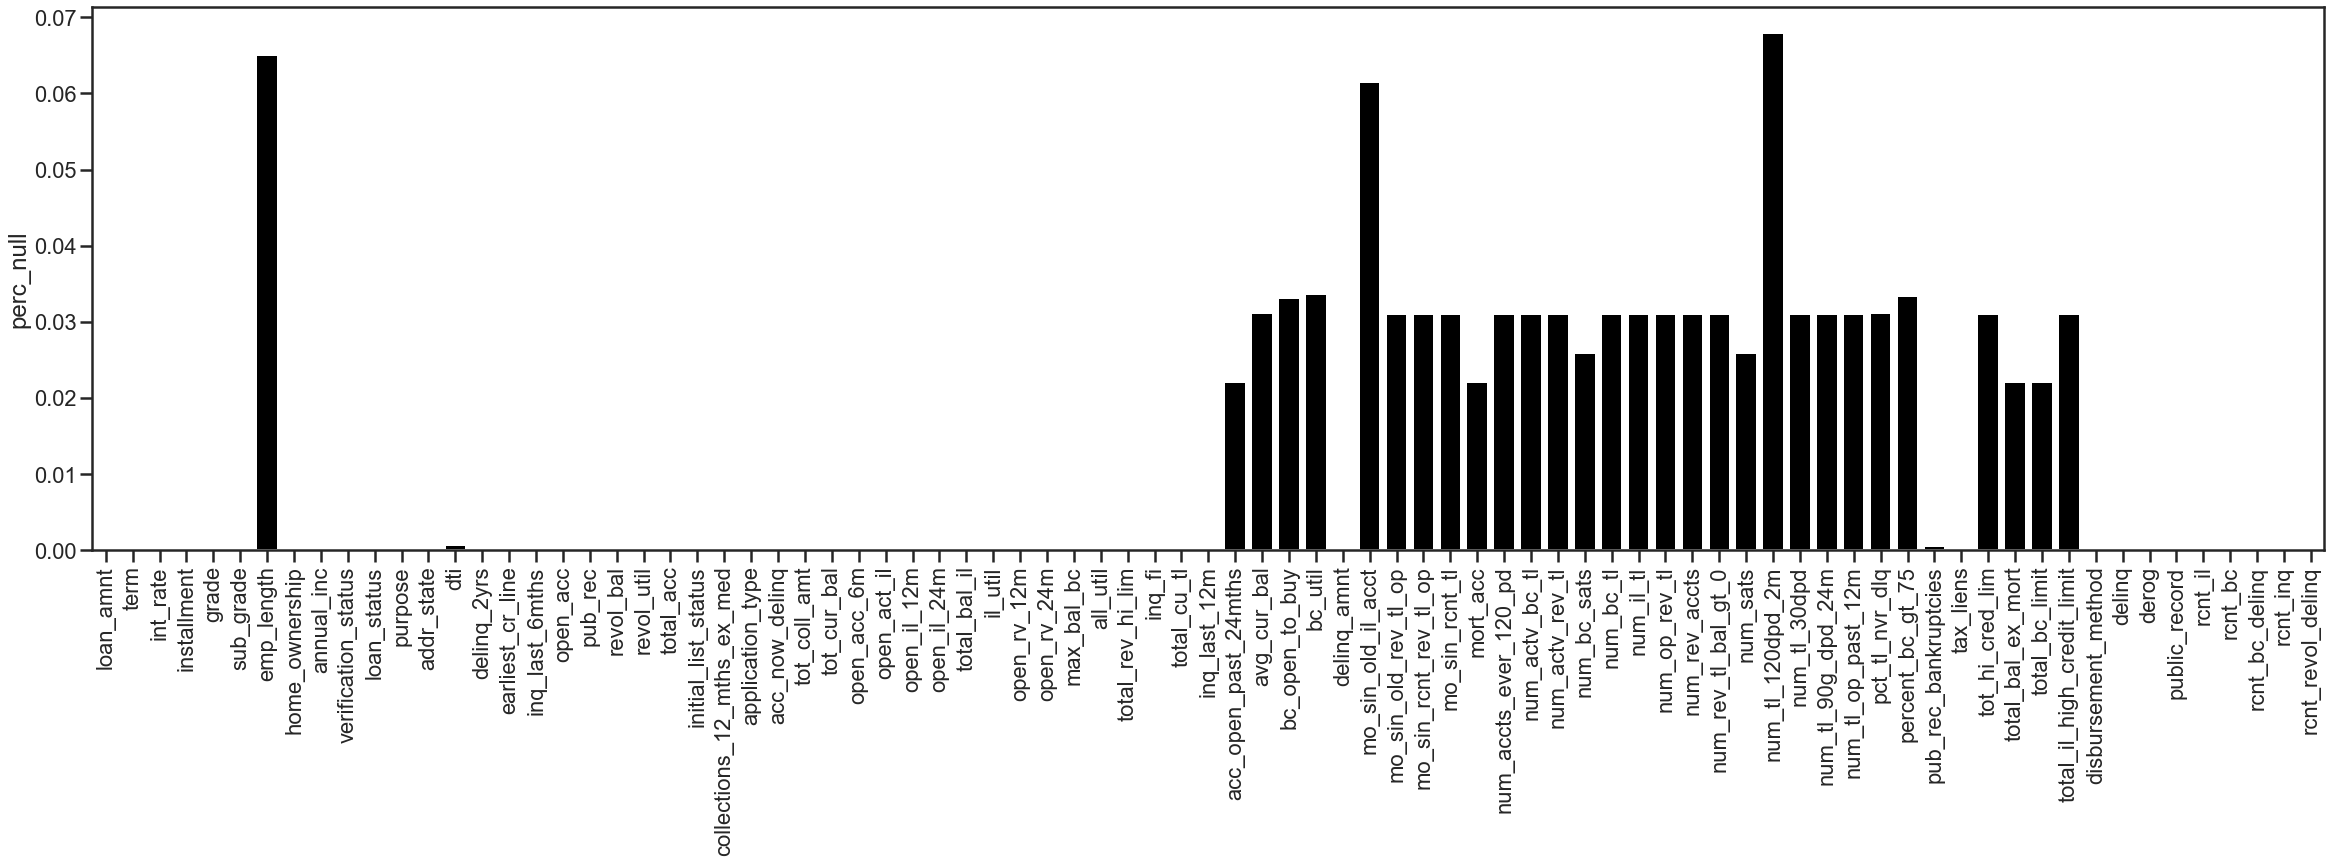

In [17]:
sns.barplot(df_nulls.index, df_nulls['perc_null'], color='Black')
plt.xticks(rotation=90)
plt.show()

In [18]:
df_clean = df.dropna()

In [19]:
def label_states(row):
    if row['loan_status'] in ['Current','Fully Paid', 'In Grace Period','Late (16-30 days)','Late (31-120 days)',\
                              'Does not meet the credit policy. Status:Fully Paid']:
        return 'Good'
    if row['loan_status'] in ['Default','Charged Off','Does not meet the credit policy. Status:Charged Off']:
        return 'Bad'
    
df_clean['loan_status'] = df_clean.apply(lambda row: label_states(row), axis=1)

In [20]:
df_clean['loan_status'].replace(to_replace='Good', value=0, inplace=True)
df_clean['loan_status'].replace(to_replace='Bad', value=1, inplace=True)

In [22]:
df_clean.emp_length = df_clean.emp_length.replace(to_replace=['10+ years','2 years','3 years','< 1 year','1 year','4 years',\
                                                              '5 years','6 years','7 years','8 years','9 years'],\
                                                              value = [10, 2, 3, 0, 1, 4, 5, 6, 7, 8, 9])
df_clean.earliest_cr_line = pd.to_datetime(df_clean.earliest_cr_line, dayfirst=True)

In [23]:
rows_to_drop = df_clean.loc[(df_clean['home_ownership']=='ANY') | (df_clean['home_ownership']=='OTHER') | (df_clean['home_ownership']=='NONE')].index
df_clean.drop(index=rows_to_drop,inplace=True)

rows_to_drop = df_clean.loc[(df_clean['purpose']=='wedding') | (df_clean['purpose']=='educational') | (df_clean['purpose']=='renewable_energy')].index
df_clean.drop(index=rows_to_drop,inplace=True)

rows_to_drop = df_clean.loc[df_clean['addr_state']=='IA'].index
df_clean.drop(index=rows_to_drop,inplace=True)

In [30]:
df_clean.to_csv('lending-club-loan-data/df_clean.csv')